# Neural Style Transfer

dated: 2 Feb 2023

Barone Francesco

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

import skimage

In [2]:
torch.manual_seed(17)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# I/O -----------------------------

#STYLE_IMAGE_FILE = "./image/vangogh.jpg"
#STYLE_IMAGE_FILE = "./image/picasso.jpg"
#STYLE_IMAGE_FILE = "./image/starry-night-rhone.jpg"
#STYLE_IMAGE_FILE = "./image/the_scream.jpg"
#STYLE_IMAGE_FILE = "./image/starry_night.jpg"
STYLE_IMAGE_FILE = "./image/afremov.jpg"

#CONTENT_IMAGE_FILE = "./image/tuebingen.jpg"
#CONTENT_IMAGE_FILE = "./image/golden_gate.jpg"
#CONTENT_IMAGE_FILE = "./image/dancing.jpg"
#CONTENT_IMAGE_FILE = "./image/garden.jpg"
CONTENT_IMAGE_FILE = "./image/padova-prato-della-valle.jpg"

In [5]:
# ALGO ----------------------------

COLOR_CONTROL = 'none'



In [6]:
assert COLOR_CONTROL in ['none', 'luminance', 'luminance_full', 'hist', 'hist_from_style' ], 'not valid option'

Hints:

* Look at this full hist matching technique https://pyimagesearch.com/2021/02/08/histogram-matching-with-opencv-scikit-image-and-python/

## model definition

In [7]:
class nst_network(nn.Module):
    """Network for Neural Style Transfer, built on top of a nst19 to return specific layer features."""

    def __init__(self, input_model, forward_hooks:list,
                 pool:str = 'max',  crop_model:bool = True
                ):
        super().__init__()

        # -----------------------------
        #       HOOKS MANAGEMENT
        # -----------------------------
        self.hooks, self.hook_handlers = {}, []
        def takeOutput(name:str):
            def hook(model, input, output):
                self.hooks[name] = output #.detach()
                # note: DO NOT DETACH! I WILL NEED GRADIENTS LATER
            return hook
        #
        #  self.hook_handlers     will store the handlers of
        #                         fwd hooks I will register
        #  self.hooks             will store the values taken with hooks
        #                         from selected layers

        self.hooks_init = forward_hooks.copy()  # keep a backup copy of this arg
        todo_hooks = set(forward_hooks)         # will use this list while I loop on network layers


        # --------------------------------------
        #              MODEL BUILD
        # --------------------------------------
        #   I loop over the input model layers,
        #  registering a hook when requested.
        # --------------------------------------
        self.model = nn.Sequential()
        
        conv_num, conv_group = 1, 1
        for layer in input_model.children():
            
            if isinstance(layer, nn.Conv2d):
                name = 'conv{}_{}'.format(conv_group, conv_num)
            
            elif isinstance(layer, nn.ReLU):
                name = 'relu{}_{}'.format(conv_group, conv_num)
                #  ^^  takes the name similar to last conv layer
                conv_num += 1

            elif isinstance(layer, (nn.MaxPool2d, nn.AvgPool2d) ):
                # take name & reset counters
                name = 'pool_{}'.format(conv_group)
                conv_group += 1;   conv_num = 1; 

                # replace pool layer with desired choice
                if   pool.lower() == 'avg':
                    layer = nn.AvgPool2d( kernel_size = layer.kernel_size,
                                          stride = layer.stride )
                elif pool.lower() == 'max':
                    layer = nn.MaxPool2d( kernel_size = layer.kernel_size,
                                          stride = layer.stride )
                else:
                    raise RuntimeError('not valid pool arg ({})'.format(pool))

            else: name = 'buh'
            
            self.model.add_module(name, layer)

            if name in todo_hooks:
                # register a hook for current layer and track its handler
                self.hook_handlers.append(
                    self.model[-1].register_forward_hook( takeOutput(name) )
                )
                todo_hooks.remove(name)

            if crop_model:
                if not todo_hooks: break
        
        # fix the weights, to be sure
        for param in self.model.parameters():
            param.requires_grad = False

        # set to eval mode
        self.model.eval()


    def forward(self, x, query : list = None):

        self.hooks = {}     # reset hooks dict

        _ = self.model(x)   # I don't care about this ...

        # ... returns the features extracted by hooks
        if query is not None:
            return [ self.hooks[key] for key in query ]
            # this is a list
        else:
            return self.hooks
            # this is a dict

### allocate the network

To do this I need the list of layer to hook from.

In [8]:
#content_layers = ['relu4_2']
#style_layers = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']

content_layers = ['conv4_2']
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']


#content_layers = ['relu1_1', 'relu2_2', 'relu4_1', 'relu5_1']
#style_layers = ['relu1_1', 'relu2_2', 'relu4_1', 'relu5_1']









**Ref**: VGG19 doc
https://pytorch.org/vision/main/models/generated/torchvision.models.vgg19.html

> Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects.

In [9]:
# take the original nst model (pretrained weights)
vgg19 = torchvision.models.vgg19(weights='IMAGENET1K_V1')

# according to VGG199 documentation, the network uses these
# parameters for input normalization
vgg19_mean = np.array( [0.485, 0.456, 0.406] )
vgg19_std = np.array( [0.229, 0.224, 0.225] )

nstn = nst_network(vgg19.features, content_layers + style_layers)
nstn.to(device);   # to suppress network layout print

## Loss functions

In [10]:
# gram matrix
def gramfn( xx : torch.Tensor , use_batch : bool = True):
    if use_batch:  batch, ch, H, W = xx.size()
    else:
        ch, H, W = xx.size()
        batch = 1
    view = xx.view(batch, ch, H*W)
    gram = torch.matmul(view, view.transpose(1,2))
    gram.div_(H*W)
    return gram

# I wrap it to look like a loss function from pytorch
class GramLoss( nn.Module ):
    def forward(self, input, target):
        # note: target should not require gradient!
        #       and must be a gram matrix
        return nn.MSELoss()( gramfn(input), target )

## Image processing

In [11]:
# pre and post processing for images
img_size = 512

img_resize = transforms.Compose([
        transforms.Resize(img_size)
])

img_network_ready = transforms.Compose([
        #transforms.ToTensor(), # NB: this scales the image to [0.0, 1.0]
        transforms.Normalize(mean = vgg19_mean, std=vgg19_std),
        transforms.Lambda(lambda x: x.mul_(255)),
])

img_network_revert = transforms.Compose([
        transforms.Lambda(lambda x: x.mul_(1./255)),
        transforms.Normalize(mean = [ 0., 0., 0. ], std = 1/vgg19_std),
        transforms.Normalize(mean = -vgg19_mean, std = [1,1,1]),
])

transf_toTen = transforms.Compose([ transforms.ToTensor() ])
transf_toPIL = transforms.Compose([ transforms.ToPILImage() ])

In [12]:
def tens2pil( img_tensor ):
    img_tensor = img_tensor.clone().detach()
    # invert the input trasform
    x = img_network_revert(img_tensor)
    # removed burned areas
    t = torch.clamp( x, min=0, max=1)
    return transf_toPIL( torch.squeeze(t) )


def load_image( source, preprocess = None, device = None, add_batch : bool = True, resize = True):

    if isinstance(source, str):
        img = Image.open(source)
    else:
        img = source # assume that this is a PIL image or ndarray
    
    img = transf_toTen( img )  # from now on this is a tensor

    if resize:
        img = img_resize( img )

    # optional: apply custom preprocess function, else use the default
    if preprocess: img = preprocess(img)
    else:          img = img_network_ready(img)

    # optional: send to device
    if device:     img = img.to(device)

    # optional: add dummy batch dimention
    if add_batch:  img = img.unsqueeze(0)
    
    return img

In [13]:
def colorcontrol_luminance_forward(img):
    """This function computes YYY repres. of a given image"""
    
    # note:  YUV works as well!
    
    gg = img.convert('YCbCr').getchannel('Y')
    return Image.merge('RGB', (gg, gg, gg) )



def colorcontrol_luminance_revert( generated_img, target, revert_fn = lambda x : x):

    # takes luminance from generated image ...
    gg = revert_fn(generated_img).convert('YCbCr').getchannel('Y')

    # ... and color from the target image
    cc = revert_fn(target).convert('YCbCr')

    merged = Image.merge('YCbCr', (gg, cc.getchannel('Cb'), cc.getchannel('Cr')) )
    return merged.convert('RGB')

In [14]:
def colorcontrol_hist_match(S : np.ndarray, C : np.ndarray, variant = 'eigs'):
    """Linear transformation of S such that mean and covariance of the RGB values
       in the new style image S' match those of C"""

    # expected input | ndarray, dtype float64, in range [0,1],
    #                | with shape (H, W, ch = 3)
    assert isinstance( S,  np.ndarray )
    assert isinstance( C,  np.ndarray )
    assert variant in ['cholesky', 'eigs']

    # 0) check that arrays are made of elements in range [0,1]
    #    and try to force this condition
    if( np.mean(S) > 10 ):   S = S/255
    if( np.mean(C) > 10 ):   C = C/255

    # 1) compute mean and covariance of pixel values
    muS = np.mean( S, axis=(0,1) )
    S_linear = (S - muS).transpose(2,0,1).reshape(3,-1)
    covS = np.dot( S_linear, S_linear.T )/S_linear.shape[1]

    muC = np.mean( C, axis=(0,1) )
    C_linear = (C - muC).transpose(2,0,1).reshape(3,-1)
    covC = np.dot( C_linear, C_linear.T )/C_linear.shape[1]

    # add a small value to covariance matrix to avoid singularity when computing inverse matrix
    covS += np.eye(covS.shape[0])*1e-8
    covC += np.eye(covC.shape[0])*1e-8


    # 2) get the transform matrix 
    if variant == 'cholesky':
        L_S = np.linalg.cholesky(covS)
        L_C = np.linalg.cholesky(covC)
        A = L_C @ np.linalg.inv(L_S)
        # A is a 3x3 matrix now

    elif variant == 'eigs':
        # eigenvectors, eigenvalues  <- linalg.eigh( M )
        lambdaS, uS = np.linalg.eigh(covS)
        sigmaS = uS @ ( np.sqrt(np.diag(lambdaS)) ) @ uS.T

        lambdaC, uC = np.linalg.eigh(covC)
        sigmaC = uC @ ( np.sqrt(np.diag(lambdaC)) ) @ uC.T

        A = sigmaC @ np.linalg.inv(sigmaS)
    

    # 3) apply the chosen linear transform
    b = muC  #- ( A @ muS )  # IDK, but it makes the image darker...
    newS = (A @ S_linear).transpose(1,0) + b
    # I transpose A@S_l to broadcast along channel dim
    
    # remove burned pixels
    newS[ newS > 1 ] = 1
    newS[ newS < 0 ] = 0

    # - the image is still linearized ... reshape!
    # - PIL likes it as an array of int values...
    return (newS*225).astype(np.uint8).reshape( S.shape[0], S.shape[1], 3 )

In [15]:
if COLOR_CONTROL in ['none', 'luminance']:
    # just load the images with the default processing
    style_image = load_image(STYLE_IMAGE_FILE, device = device)
    content_image = load_image(CONTENT_IMAGE_FILE, device = device)

    content_image_bak = content_image.clone()


elif COLOR_CONTROL == 'luminance_full':
    style_image_original = Image.open(STYLE_IMAGE_FILE)
    content_image_original = Image.open(CONTENT_IMAGE_FILE)

    style_image = load_image(
        colorcontrol_luminance_forward(style_image_original), device = device
    )

    content_image = load_image(
        colorcontrol_luminance_forward(content_image_original), device = device
    )

    content_image_bak = load_image(CONTENT_IMAGE_FILE, device = device)

    del style_image_original, content_image_original


elif COLOR_CONTROL in ['hist']:
    style_image_original = Image.open(STYLE_IMAGE_FILE)
    content_image_original = Image.open(CONTENT_IMAGE_FILE)

    # preprocess the style image to match the hist of content
    tmp = colorcontrol_hist_match(np.array(style_image_original ), 
                                  np.array(content_image_original) )
    style_image = load_image(
        Image.fromarray( tmp ), device = device
    )

    content_image = load_image( content_image_original, device = device )

    del style_image_original, content_image_original

elif COLOR_CONTROL in ['hist_from_style']:
    style_image_original = Image.open(STYLE_IMAGE_FILE)
    content_image_original = Image.open(CONTENT_IMAGE_FILE)

    # preprocess the content image to match the hist of style
    tmp = colorcontrol_hist_match(np.array( content_image_original ),
                                  np.array( style_image_original ) )
    content_image = load_image(
        Image.fromarray( tmp ), device = device
    )

    style_image = load_image( style_image_original, device = device )

    del style_image_original, content_image_original

generated_img = torch.autograd.Variable(content_image.clone(), requires_grad=True)

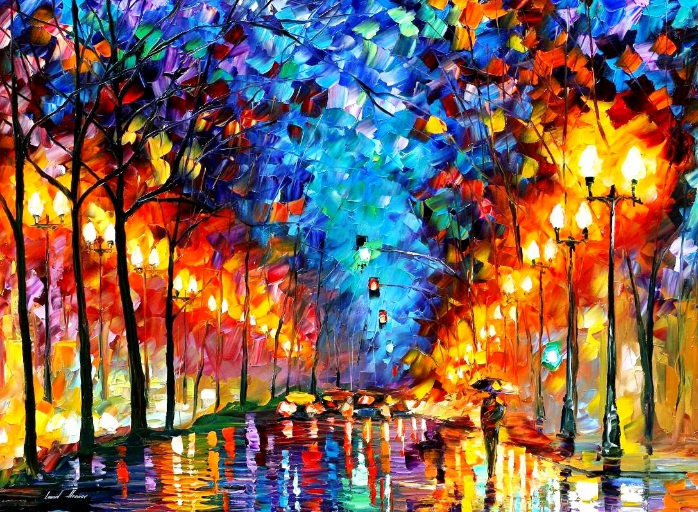

In [16]:
tens2pil(style_image)

### compute target features

In [17]:
class catLoss():
    """This class collects all the useful stuff to compute & track the losses"""
    def __init__(self, layers : list, targets : list,
                 lossfn = lambda x: x,   # loss function to call for all values in this collection
                 #fn = lambda x: x,       # function to process input when computing loss
                 weights : list = None,  # if provided, will use the given weights
                 scale : float = 1.0     # general weight scale factor 
                ):
        assert len(targets) == len(layers)

        n = len(layers)

        self.layers = layers
        self.targets = targets
        self.lossfn = lossfn

        if weights is None:
            self.weights = [ 1/n ]*n
        else:
            assert len(weights) == n
            self.weights = weights

        self.hist = []
        self.scale = scale

    def compute_loss(self, feats : list):
        tmp = self.scale*sum([ self.weights[ii]*self.lossfn(ft, self.targets[ii]) for ii, ft in enumerate(feats) ])

        self.hist.append( tmp.item() )
        return tmp
    
    def compute_loss_from_dict(self, feats : dict):
        feats = [ feats[key] for key in self.layers ]
        
        tmp = self.scale*sum([ self.weights[ii]*self.lossfn(ft, self.targets[ii]) for ii, ft in enumerate(feats) ])
        self.hist.append( tmp.item() )
        return tmp

In [18]:
def compute_feat( model, image, layers, fn = lambda x : x) -> list:
    return [ fn(x).detach().to(device) for x in model(image, layers) ]

target_style_feat = compute_feat(nstn, style_image, style_layers, gramfn)
target_content_feat = compute_feat(nstn, content_image, content_layers)

## NST in action

In [19]:
catStyle   = catLoss(style_layers, target_style_feat, GramLoss())#, weights = [ 1e2/n**2 for n in [64,128,256,512,512] ])
# ^ weights = [ 1e2/n**2 for n in [64,128,256,512,512] ]
# v scale = 1e0
catContent = catLoss(content_layers, target_content_feat, nn.MSELoss(), scale = 1e-2 )  #reduction='sum'

iter_max = 400

optimizer = torch.optim.LBFGS([generated_img])

In [20]:
# run style transfer

iter_count = 0
def closure() -> torch.Tensor:
    global iter_count

    optimizer.zero_grad()
    
    feats = nstn( generated_img )

    loss_style = catStyle.compute_loss_from_dict( feats )
    loss_cont = catContent.compute_loss_from_dict( feats )
    loss = loss_style + loss_cont

    loss.backward()
    
    if iter_count%tqdm_update == 0:
        pbar.update(tqdm_update)
        pbar.set_postfix_str("loss = {}".format( loss.item() ) )
    iter_count += 1
    return loss
    

with tqdm(total=iter_max, desc='Neural Style transfer') as pbar:
    tqdm_update = 20
    while iter_count <= iter_max:
        optimizer.step(closure)

Neural Style transfer:  30%|███       | 120/400 [00:07<00:18, 14.80it/s, loss = 1304819072.0]  

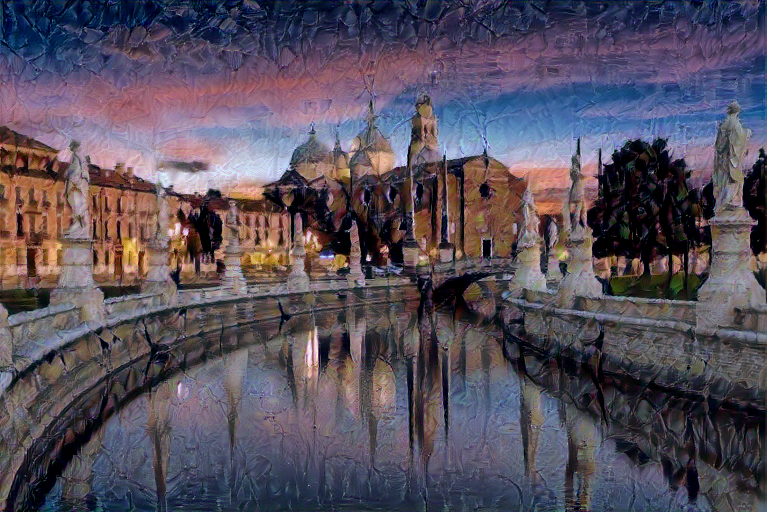

In [ ]:
# print the result

if COLOR_CONTROL in ['luminance', 'luminance_full']:
    # cc with luminance requires a revert of image coloring
    res = colorcontrol_luminance_revert( generated_img, content_image_bak, revert_fn = tens2pil )
else:
    res = tens2pil(generated_img)

res

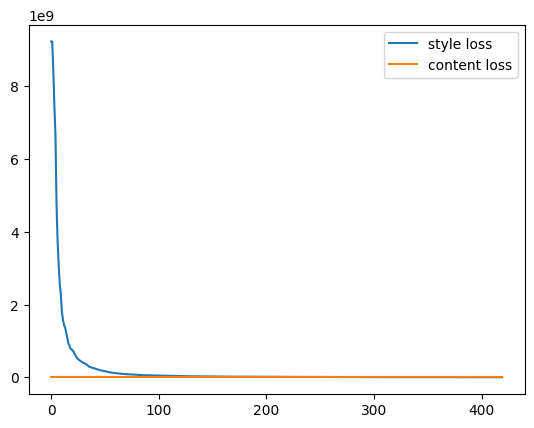

In [ ]:
plt.plot( catStyle.hist, label = 'style loss')
plt.plot( catContent.hist, label = 'content loss')
plt.legend()
plt.show()